# 로지스틱 회귀의 독립변수 보고

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), '../../../../'))
sys.path.append(work_path)
from helper.regrassion import *
from helper.plot import *
from helper.util import *
from helper.analysis import *
from helper.classification import *
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
from statsmodels.api import Logit, add_constant

### [2] 데이터 가져오기

오렌지와 자몽의 지름, 무게, 색상 데이터

> https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit

| 변수 | 설명 |
|---|---|
| name | 종속변수. `orange`, `grapefruit` |
| diameter | 지름(센티미터) |
| weight | 무게(그램) |
| red | RGB 스캔의 평균 빨간색 판독값(`0~255`) |
| green | RGB 스캔의 평균 녹색 판독값(`0~255`) |
| blue | RGB 스캔의 평균 파란색 판독값(`0~255`) |

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/citrus.xlsx", categories=['name'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      10000 non-null  category
 1   diameter  10000 non-null  float64 
 2   weight    10000 non-null  float64 
 3   red       10000 non-null  int64   
 4   green     10000 non-null  int64   
 5   blue      10000 non-null  int64   
dtypes: category(1), float64(2), int64(3)
memory usage: 400.6 KB
None

데이터프레임 상위 5개 행
+----+--------+------------+----------+-------+---------+--------+
|    | name   |   diameter |   weight |   red |   green |   blue |
|----+--------+------------+----------+-------+---------+--------|
|  0 | orange |       2.96 |    86.76 |   172 |      85 |      2 |
|  1 | orange |       3.91 |    88.05 |   166 |      78 |      3 |
|  2 | orange |       4.42 |    95.17 |   156 |      81 |      2 |
|  3 | orange |       4.47 |     95.6 |   163 |      81 |      4 |
|  4 | orange |   

## #02. 탐색적 데이터 분석

### [1] 상자그림

데이터 분포 확인

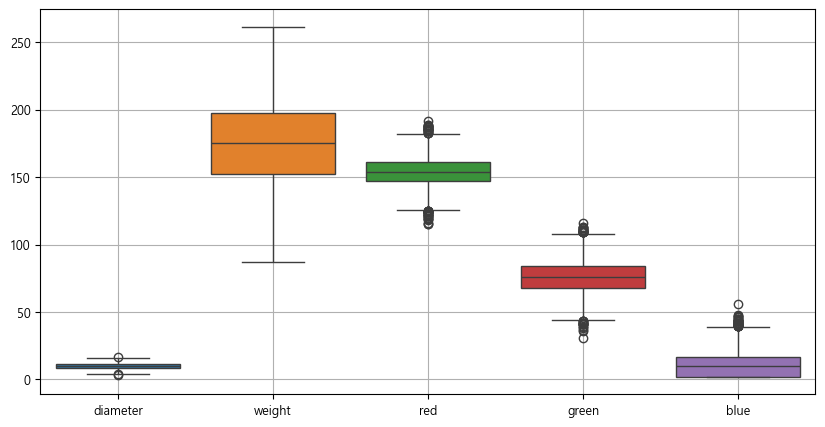

In [3]:
my_boxplot(origin)

## #03. 데이터 전처리

### [1] 데이터 스케일링

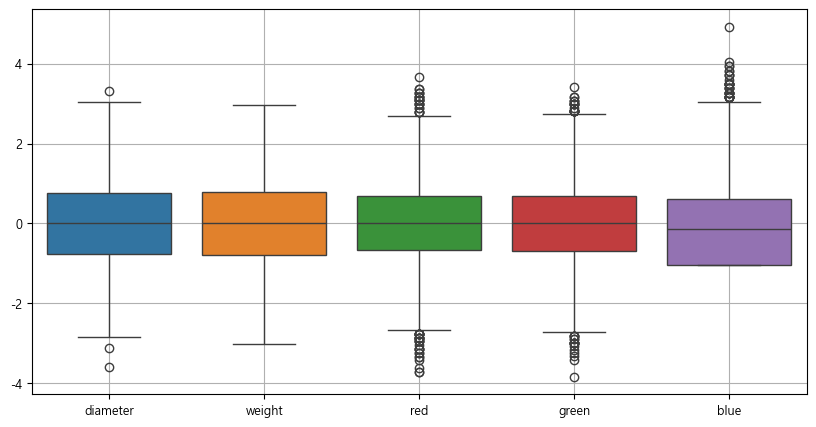

In [4]:
df = my_standard_scaler(origin, yname='name')
my_boxplot(df)

### [2] 데이터 라벨링

로지스틱 회귀의 종속변수는 반드시 `0`, `1`로 구분된 정수형 이진값으로 구성되어야 한다.

> util.py 파일에 `my_labelling()`함수를 구현

In [5]:
df2 = my_labelling(df, "name")
my_pretty_table(df2.head())

+----+------------+----------+----------+-----------+-----------+--------+
|    |   diameter |   weight |      red |     green |      blue |   name |
|----+------------+----------+----------+-----------+-----------+--------|
|  0 |   -3.60195 | -3.02255 |  1.73998 |   0.76781 |  -1.03337 |      1 |
|  1 |   -3.11421 | -2.97839 |  1.16485 |   0.16992 | -0.923007 |      1 |
|  2 |   -2.85237 | -2.73465 | 0.206299 |  0.426159 |  -1.03337 |      1 |
|  3 |    -2.8267 | -2.71992 | 0.877283 |  0.426159 | -0.812642 |      1 |
|  4 |   -2.82156 | -2.71445 | 0.685574 | -0.342557 | -0.260815 |      1 |
+----+------------+----------+----------+-----------+-----------+--------+


## #04. statsmodels 패키지를 활용한 로지스틱 분석

In [6]:
y = df2['name']
x = df2.drop('name', axis=1)

model = Logit(y, add_constant(x))
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.116766
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                   name   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Tue, 05 Mar 2024   Pseudo R-squ.:                  0.8315
Time:                        10:41:58   Log-Likelihood:                -1167.7
converged:                       True   LL-Null:                       -6931.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9649      0.077     12.538      0.000       0.814       1.116
diameter     -53.4531      2

In [23]:
fit.params

const        0.964944
diameter   -53.453121
weight      48.651513
red          0.575821
green        1.277025
blue        -1.089191
dtype: float64

## #05 sklearn 을 활용한 로지스틱 분석

### [1] 분석 모형 만들기

> statsmodels와 같은 결과값을 만드는 것이 목표이므로 훈련/검증 데이터 분할 없이 모든 데이터를 훈련용으로 사용

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  1 | 0.001 | l2        |            0.8796 |
| 16 |   100 | l2        |             0.873 |
|  4 |  0.01 | l2        |             0.865 |
| 13 |    10 | l2        |            0.8613 |
|  7 |   0.1 | l2        |            0.8478 |
| 10 |     1 | l2        |            0.8474 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 | 설명                                                      |
|-------------------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.626174 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |       0.9269 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision)       |     0.921921 | 양성으로 예측한 결과

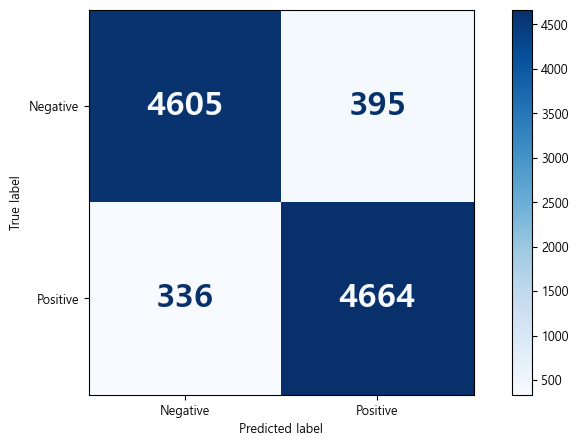


[ROC/PR Curve]


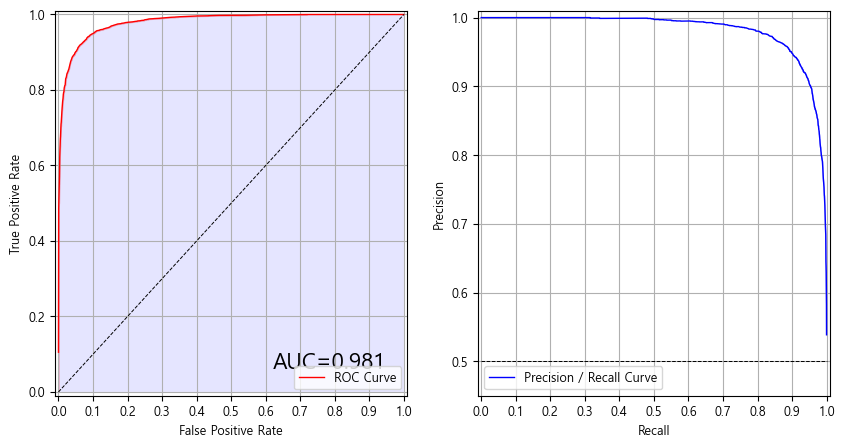


[학습곡선]


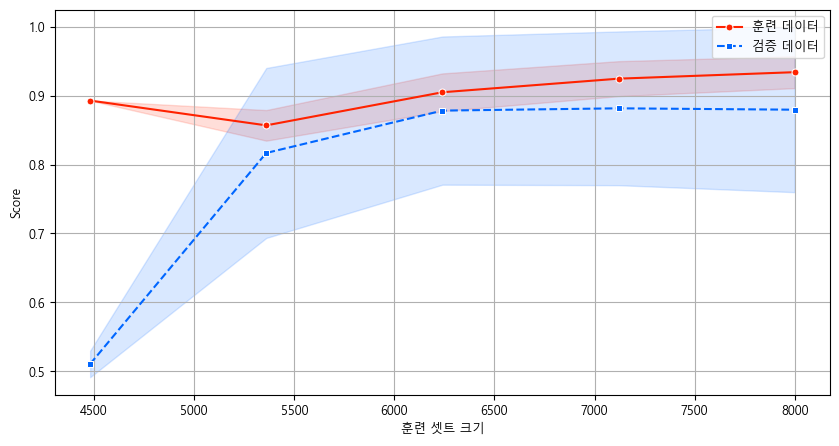

+----+------------+------------+--------------------+------------+----------+------------+------------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |        t |   유의확률 |   OddsRate |
|----+------------+------------+--------------------+------------+----------+------------+------------|
|  0 | name       | diameter   |            -0.7607 |      0.832 |  -0.9147 |       0.36 |   0.467339 |
|  1 | name       | weight     |            -0.7243 |      0.827 |  -0.8761 |      0.381 |   0.484664 |
|  2 | name       | red        |             0.2643 |      0.028 |   9.3426 |          0 |    1.30252 |
|  3 | name       | green      |             0.5188 |      0.031 |  16.6638 |          0 |    1.68001 |
|  4 | name       | blue       |            -0.4619 |       0.03 | -15.1944 |          0 |   0.630085 |
+----+------------+------------+--------------------+------------+----------+------------+------------+


LogisticRegression(C=0.001, max_iter=500, n_jobs=-1)

In [7]:
estimator = my_logistic_classification(x_train=x, y_train=y)
estimator

### [2] 절편

In [8]:
estimator.intercept_

array([-0.01254428])

### [3] 회귀계수

In [9]:
estimator.coef_

array([[-0.76065576, -0.72432352,  0.26429321,  0.51884527, -0.4619306 ]])

In [10]:
estimator.feature_names_in_

array(['diameter', 'weight', 'red', 'green', 'blue'], dtype=object)

In [11]:
for i,v in enumerate(estimator.feature_names_in_):
    print('%s: %0.4f' % (v, estimator.coef_[0][i]))

diameter: -0.7607
weight: -0.7243
red: 0.2643
green: 0.5188
blue: -0.4619


### [4] 추정확률

In [12]:
y_pred_proba = estimator.predict_proba(x)
y_pred_proba

array([[0.00192252, 0.99807748],
       [0.004792  , 0.995208  ],
       [0.00745881, 0.99254119],
       ...,
       [0.98272598, 0.01727402],
       [0.99263242, 0.00736758],
       [0.98717466, 0.01282534]])

### [5] 추정확률의 길이 (=샘플수)

In [13]:
n = len(y_pred_proba)
n

10000

### [6] 계수의 수 + 1(절편)

In [14]:
m = len(estimator.coef_[0]) + 1

### [7] 절편과 계수를 하나의 배열로 결합

In [15]:
coefs = np.concatenate([estimator.intercept_, estimator.coef_[0]])
coefs

array([-0.01254428, -0.76065576, -0.72432352,  0.26429321,  0.51884527,
       -0.4619306 ])

### [8] 상수항 추가

In [16]:
x_full = np.matrix(np.insert(np.array(x), 0 , 1, axis=1))
print(x_full)

[[ 1.         -3.60195018 -3.02255396  1.73997781  0.76780981 -1.03337209]
 [ 1.         -3.11420697 -2.978392    1.16484825  0.16992022 -0.92300682]
 [ 1.         -2.85236589 -2.73464536  0.20629897  0.42615862 -1.03337209]
 ...
 [ 1.          2.88246734  2.78833864  1.3565581   0.51157142  0.95320276]
 [ 1.          3.05189393  2.91295068 -1.13567001 -0.34255657 -0.04008467]
 [ 1.          3.32400329  2.95985137 -0.17712073 -0.17173097 -1.03337209]]


### [9] 변수의 길이를 활용하여 모든 값이 0인 행렬 생성

In [17]:
ans = np.zeros((m, m))
ans

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

### [10] 표준오차

In [18]:
for i in range(n):
    ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * y_pred_proba[i,1] * y_pred_proba[i,0]

vcov = np.linalg.inv(np.matrix(ans))
se = np.sqrt(np.diag(vcov))
se

array([0.02801155, 0.83154738, 0.82677303, 0.02828902, 0.03113611,
       0.0304013 ])

### [11] T값

In [19]:
t = coefs/se
t

array([ -0.44782524,  -0.91474735,  -0.87608508,   9.34260773,
        16.6637787 , -15.1944349 ])

### [12] p-value

In [20]:
p_values =(1- norm.cdf(abs(t)))* 2
p_values

array([0.65427933, 0.36032428, 0.38098378, 0.        , 0.        ,
       0.        ])

### [13] Odds Rate(오즈비)

성공할 확률 / 실패할 확률

계수값에 대해 'np.exp()' 함수 적용하면 계수들을 오즈값으로 변환

In [21]:
np.exp(estimator.coef_[0])

array([0.46735985, 0.48465232, 1.30251005, 1.68008649, 0.63006606])

### [14] 결과표 생성

In [26]:
xnames = estimator.feature_names_in_

result_df = DataFrame({
    "종속변수": [y.name] * len(xnames),
    "독립변수": xnames,
    "B(비표준화 계수)": np.round(estimator.coef_[0], 4),
    "표준오차": np.round(se[1:],3),
    "t": np.round(t[1:], 4),
    "유의확률": np.round(p_values[1:], 3),
    "OddsRate": np.round(np.exp(estimator.coef_[0]),4)
    
})

my_pretty_table(result_df)

+----+------------+------------+--------------------+------------+----------+------------+------------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |        t |   유의확률 |   OddsRate |
|----+------------+------------+--------------------+------------+----------+------------+------------|
|  0 | name       | diameter   |            -0.7607 |      0.832 |  -0.9147 |       0.36 |     0.4674 |
|  1 | name       | weight     |            -0.7243 |      0.827 |  -0.8761 |      0.381 |     0.4847 |
|  2 | name       | red        |             0.2643 |      0.028 |   9.3426 |          0 |     1.3025 |
|  3 | name       | green      |             0.5188 |      0.031 |  16.6638 |          0 |     1.6801 |
|  4 | name       | blue       |            -0.4619 |       0.03 | -15.1944 |          0 |     0.6301 |
+----+------------+------------+--------------------+------------+----------+------------+------------+


## #06. 모듈화 기능 확인

In [24]:
my_classification_report(estimator, x, y)

+----+------------+------------+--------------------+------------+----------+------------+------------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |        t |   유의확률 |   OddsRate |
|----+------------+------------+--------------------+------------+----------+------------+------------|
|  0 | name       | diameter   |            -0.7607 |      0.832 |  -0.9147 |       0.36 |   0.467339 |
|  1 | name       | weight     |            -0.7243 |      0.827 |  -0.8761 |      0.381 |   0.484664 |
|  2 | name       | red        |             0.2643 |      0.028 |   9.3426 |          0 |    1.30252 |
|  3 | name       | green      |             0.5188 |      0.031 |  16.6638 |          0 |    1.68001 |
|  4 | name       | blue       |            -0.4619 |       0.03 | -15.1944 |          0 |   0.630085 |
+----+------------+------------+--------------------+------------+----------+------------+------------+
